**Problem Statement**

With the increasing adoption of bike-sharing services in urban areas, understanding usage patterns is crucial for efficient system management and user satisfaction. This project analyzes the 2024 Bluebikes trip data in Boston to identify trends in user behavior, trip durations, and station activity. Through detailed data cleaning and feature engineering, the goal is to uncover actionable insights that can support decision-making around bike availability, station placement, and operational efficiency. By evaluating temporal trends, trip distances, and station-level demand, this analysis aims to help optimize resource allocation and improve the overall user experience.

The key business questions driving this analysis are:

1. What are the peak hours and days for Bluebikes usage across different seasons?
2. Which stations experience the highest demand for bike pickups and returns?
3. How does trip duration vary based on time of day and user type?

In [1]:
# Install Necessary Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

In [2]:
# Load all CSV files
csv_files = sorted(glob.glob('/Users/prateek/Documents/Projects/BlueBikes/2024 BlueBikes Dataset/2024*-bluebikes-tripdata.csv'))
df_list = [pd.read_csv(f) for f in csv_files]

# Merge all monthly CSVs
data = pd.concat(df_list, ignore_index=True)
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,D2F4A4783B230A84,electric_bike,2024-01-31 12:16:49,2024-01-31 12:21:02,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362357,-71.088163,42.365070,-71.103100,member
1,D305CEFFD4558633,classic_bike,2024-01-12 08:14:16,2024-01-12 08:19:48,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362500,-71.088220,42.365070,-71.103100,member
2,02009BB4EBA0D1F6,electric_bike,2024-01-29 15:00:05,2024-01-29 15:05:47,One Memorial Drive,M32053,Kennedy-Longfellow School 158 Spring St,M32065,42.361697,-71.080273,42.369553,-71.085790,member
3,04C230C1C39071F7,classic_bike,2024-01-09 16:33:40,2024-01-09 17:00:41,Ames St at Main St,M32037,Brookline Town Hall,K32005,42.362500,-71.088220,42.333765,-71.120464,member
4,CEAFE67E28B43852,classic_bike,2024-01-23 10:19:21,2024-01-23 10:31:39,Mass Ave T Station,C32063,Chinatown T Stop,D32019,42.341356,-71.083370,42.352409,-71.062679,member


In [3]:
# Check the shape of the data
data.shape

(4751790, 13)

In [4]:
# Check all the information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4751790 entries, 0 to 4751789
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 471.3+ MB


## Data Cleaning

In [5]:
# Check the number of missing values in each column
data.isnull().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name    1435
start_station_id      1435
end_station_name      8225
end_station_id        8628
start_lat                0
start_lng                0
end_lat               3507
end_lng               3507
member_casual            0
dtype: int64

In [6]:
# Drop Missing Values
data.dropna(inplace=True)

In [7]:
# Check the number of duplicated values in the dataset
data.duplicated().sum()

np.int64(0)

In [8]:
# Convert date columns 
data['started_at'] = pd.to_datetime(data['started_at'], format='mixed', errors='coerce')
data['ended_at'] = pd.to_datetime(data['ended_at'], format='mixed', errors='coerce')


In [9]:
data.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4742246 entries, 0 to 4751789
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 506.5+ MB


In [11]:
# Calculate trip duration in minutes
data['trip_duration_min'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60
data['trip_duration_min']

0           4.216667
1           5.533333
2           5.700000
3          27.016667
4          12.300000
             ...    
4751785    13.871133
4751786     3.717650
4751787    13.257017
4751788     1.527783
4751789     6.140400
Name: trip_duration_min, Length: 4742246, dtype: float64

In [12]:
# Remove outlier trips
data = data[(data['trip_duration_min'] >= 1) & (data['trip_duration_min'] <= 60)]

In [13]:
print(f"Data shape after cleaning: {data.shape}")

Data shape after cleaning: (4630454, 14)


## Feature Engineering

In [14]:
# Extracting time-based features
data['date'] = data['started_at'].dt.date
data['hour'] = data['started_at'].dt.hour
data['weekday'] = data['started_at'].dt.weekday
data['month'] = data['started_at'].dt.month
data['day'] = data['started_at'].dt.day
data['is_weekend'] = data['weekday'].isin(['Saturday', 'Sunday'])

In [15]:
data.head(20)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration_min,date,hour,weekday,month,day,is_weekend
0,D2F4A4783B230A84,electric_bike,2024-01-31 12:16:49,2024-01-31 12:21:02,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362357,-71.088163,42.365070,-71.103100,member,4.216667,2024-01-31,12,2,1,31,False
1,D305CEFFD4558633,classic_bike,2024-01-12 08:14:16,2024-01-12 08:19:48,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362500,-71.088220,42.365070,-71.103100,member,5.533333,2024-01-12,8,4,1,12,False
2,02009BB4EBA0D1F6,electric_bike,2024-01-29 15:00:05,2024-01-29 15:05:47,One Memorial Drive,M32053,Kennedy-Longfellow School 158 Spring St,M32065,42.361697,-71.080273,42.369553,-71.085790,member,5.700000,2024-01-29,15,0,1,29,False
3,04C230C1C39071F7,classic_bike,2024-01-09 16:33:40,2024-01-09 17:00:41,Ames St at Main St,M32037,Brookline Town Hall,K32005,42.362500,-71.088220,42.333765,-71.120464,member,27.016667,2024-01-09,16,1,1,9,False
4,CEAFE67E28B43852,classic_bike,2024-01-23 10:19:21,2024-01-23 10:31:39,Mass Ave T Station,C32063,Chinatown T Stop,D32019,42.341356,-71.083370,42.352409,-71.062679,member,12.300000,2024-01-23,10,1,1,23,False
5,07C37921B6834977,classic_bike,2024-01-26 12:35:20,2024-01-26 12:54:06,St. Alphonsus St at Tremont St,B32063,Stuart St at Charles St,D32011,42.333293,-71.101246,42.351146,-71.066289,member,18.766667,2024-01-26,12,4,1,26,False
6,F93AF0484FBA82B2,classic_bike,2024-01-23 12:50:25,2024-01-23 12:55:28,Ames St at Main St,M32037,Kennedy-Longfellow School 158 Spring St,M32065,42.362500,-71.088220,42.369553,-71.085790,member,5.050000,2024-01-23,12,1,1,23,False
7,2AC091C3370D3F31,classic_bike,2024-01-25 12:33:47,2024-01-25 12:40:51,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362500,-71.088220,42.365070,-71.103100,member,7.066667,2024-01-25,12,3,1,25,False
8,D4EB63EDC18B910E,classic_bike,2024-01-24 16:26:29,2024-01-24 16:31:55,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362500,-71.088220,42.365070,-71.103100,member,5.433333,2024-01-24,16,2,1,24,False
9,BE62062872481B25,classic_bike,2024-01-31 17:17:01,2024-01-31 17:21:44,Ames St at Main St,M32037,Kennedy-Longfellow School 158 Spring St,M32065,42.362500,-71.088220,42.369553,-71.085790,member,4.716667,2024-01-31,17,2,1,31,False


1. Trip Distance Proxy (if coordinates available)

If your data includes start_lat, start_lng, end_lat, end_lng, we can calculate:

* **Haversine distance** between start and end (a proxy for trip distance)

In [16]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

data['distance_km'] = data.apply(lambda row: haversine(
    row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']), axis=1)

data['distance_km']

0          1.263733
1          1.255494
2          0.984109
3          4.151045
4          2.098050
             ...   
4751785    1.503719
4751786    1.062302
4751787    2.422656
4751788    0.306898
4751789    1.062302
Name: distance_km, Length: 4630454, dtype: float64

In [17]:
'''
# Another way to calculate distance
from geopy.distance import geodesic

# Compute distance in km between start and end locations
data['distance_km_1'] = data.apply(
    lambda row: geodesic(
        (row['start_lat'], row['start_lng']),
        (row['end_lat'], row['end_lng'])
    ).km if pd.notnull(row['start_lat']) and pd.notnull(row['end_lat']) else np.nan,
    axis=1
)

data['distance_km_1']
'''

"\n# Another way to calculate distance\nfrom geopy.distance import geodesic\n\n# Compute distance in km between start and end locations\ndata['distance_km_1'] = data.apply(\n    lambda row: geodesic(\n        (row['start_lat'], row['start_lng']),\n        (row['end_lat'], row['end_lng'])\n    ).km if pd.notnull(row['start_lat']) and pd.notnull(row['end_lat']) else np.nan,\n    axis=1\n)\n\ndata['distance_km_1']\n"

2. Trip Speed (km/h)

In [18]:
# Calculate speed in km/h
data['speed_kmph'] = data['distance_km'] / (data['trip_duration_min'] / 60)
data['speed_kmph']

0          17.981975
1          13.613794
2          10.359038
3           9.218853
4          10.234388
             ...    
4751785     6.504380
4751786    17.144729
4751787    10.964711
4751788    12.052694
4751789    10.380122
Name: speed_kmph, Length: 4630454, dtype: float64

3. Round Trip Flag

In [19]:
data['is_round_trip'] = data['start_station_name'] == data['end_station_name']
data['is_round_trip'].value_counts()

is_round_trip
False    4498300
True      132154
Name: count, dtype: int64

4. Lag Features / Historical Averages (for modeling)
* Average trip duration from that station
* Average speed by weekday/hour

In [20]:
# Average trip duration by start station
station_avg_duration = data.groupby('start_station_name')['trip_duration_min'].mean().reset_index(name='avg_station_trip_duration')
data = data.merge(station_avg_duration, on='start_station_name', how='left')

In [21]:
data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,date,hour,weekday,month,day,is_weekend,distance_km,speed_kmph,is_round_trip,avg_station_trip_duration
0,D2F4A4783B230A84,electric_bike,2024-01-31 12:16:49.000,2024-01-31 12:21:02.000,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362357,-71.088163,...,2024-01-31,12,2,1,31,False,1.263733,17.981975,False,11.705661
1,D305CEFFD4558633,classic_bike,2024-01-12 08:14:16.000,2024-01-12 08:19:48.000,Ames St at Main St,M32037,Central Square at Mass Ave / Essex St,M32011,42.362500,-71.088220,...,2024-01-12,8,4,1,12,False,1.255494,13.613794,False,11.705661
2,02009BB4EBA0D1F6,electric_bike,2024-01-29 15:00:05.000,2024-01-29 15:05:47.000,One Memorial Drive,M32053,Kennedy-Longfellow School 158 Spring St,M32065,42.361697,-71.080273,...,2024-01-29,15,0,1,29,False,0.984109,10.359038,False,13.231802
3,04C230C1C39071F7,classic_bike,2024-01-09 16:33:40.000,2024-01-09 17:00:41.000,Ames St at Main St,M32037,Brookline Town Hall,K32005,42.362500,-71.088220,...,2024-01-09,16,1,1,9,False,4.151045,9.218853,False,11.705661
4,CEAFE67E28B43852,classic_bike,2024-01-23 10:19:21.000,2024-01-23 10:31:39.000,Mass Ave T Station,C32063,Chinatown T Stop,D32019,42.341356,-71.083370,...,2024-01-23,10,1,1,23,False,2.098050,10.234388,False,13.330324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4630449,D02800DF593AFDC5,classic_bike,2024-12-24 16:28:11.746,2024-12-24 16:42:04.014,Elevate at One Leighton,M32092,MIT Carleton St at Amherst St,M32070,42.369931,-71.073526,...,2024-12-24,16,1,12,24,False,1.503719,6.504380,False,14.219512
4630450,84E40AD1389B426A,electric_bike,2024-12-10 18:58:36.519,2024-12-10 19:02:19.578,Park Plaza at Charles St S.,D32042,Columbus Ave at W. Canton St,C32077,42.351828,-71.067811,...,2024-12-10,18,1,12,10,False,1.062302,17.144729,False,15.234019
4630451,D376AC23CD592C8C,classic_bike,2024-12-10 06:49:55.046,2024-12-10 07:03:10.467,Tremont St at W. Dedham St,C32060,HMS/HSPH - Avenue Louis Pasteur at Longwood Ave,B32003,42.342549,-71.074214,...,2024-12-10,6,1,12,10,False,2.422656,10.964711,False,11.928791
4630452,2604733C8EAF22A6,classic_bike,2024-12-15 18:57:36.149,2024-12-15 18:59:07.816,Tremont St at W. Dedham St,C32060,Columbus Ave at W. Canton St,C32077,42.342549,-71.074214,...,2024-12-15,18,6,12,15,False,0.306898,12.052694,False,11.928791


## Exploratory Data Analysis

1. Trip Duration Analysis

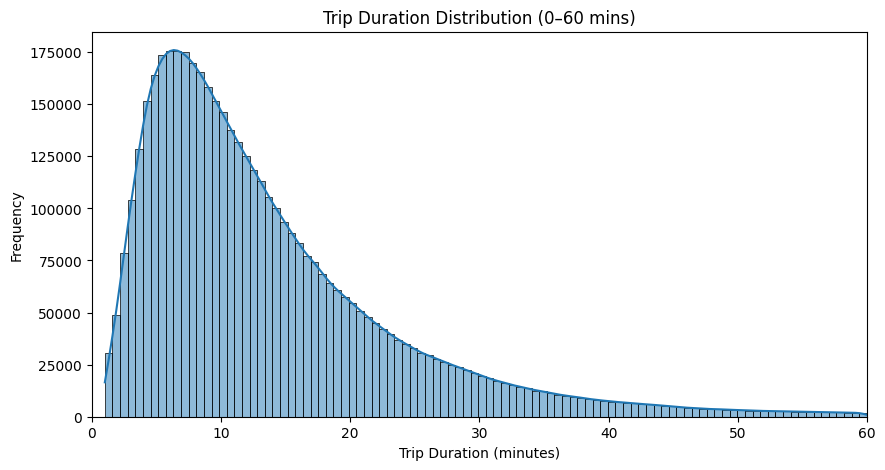

count    4.630454e+06
mean     1.366228e+01
std      9.862526e+00
min      1.000000e+00
25%      6.650000e+00
50%      1.093807e+01
75%      1.774292e+01
max      6.000000e+01
Name: trip_duration_min, dtype: float64

In [22]:
# Plot trip duration distribution (log scale to handle skewness)
plt.figure(figsize=(10, 5))
sns.histplot(data['trip_duration_min'], bins=100, kde=True)
plt.xlim(0, 60)
plt.title("Trip Duration Distribution (0–60 mins)")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency")
plt.show()

# Summary stats
data['trip_duration_min'].describe()

2. Temporal Patterns

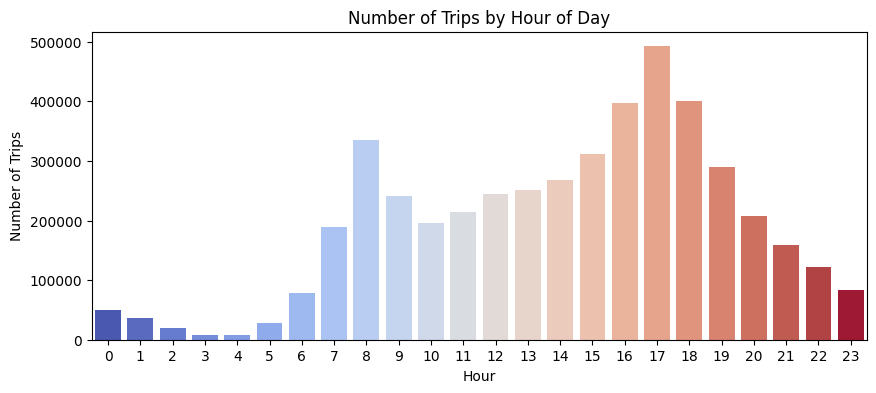

In [23]:
# Trips by hour of day
plt.figure(figsize=(10, 4))
sns.countplot(x='hour', data=data, hue='hour', palette='coolwarm', legend=False)
plt.title("Number of Trips by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.show()

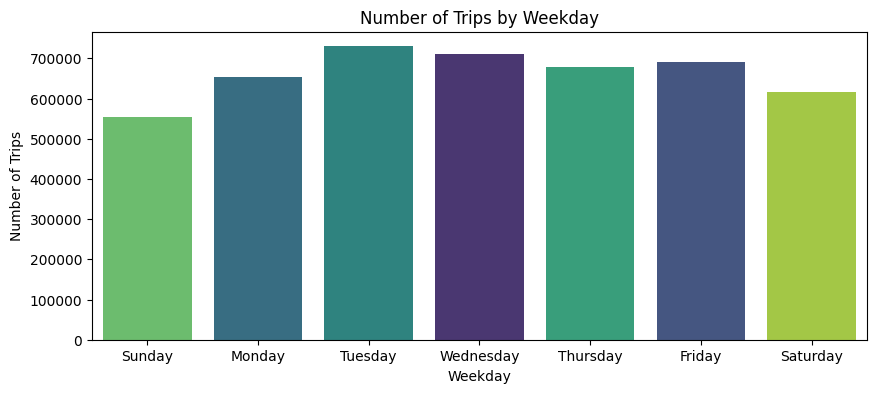

In [ ]:
# Convert Numeric weekday to day names
import calendar

# Map integers to weekday names
data['weekday'] = data['weekday'].apply(lambda x: calendar.day_name[x])

# Trips by day of week
plt.figure(figsize=(10, 4))
order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.countplot(x='weekday', data=data, order=order, hue='weekday', palette='viridis', legend=False)
plt.title("Number of Trips by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Trips")
plt.show()

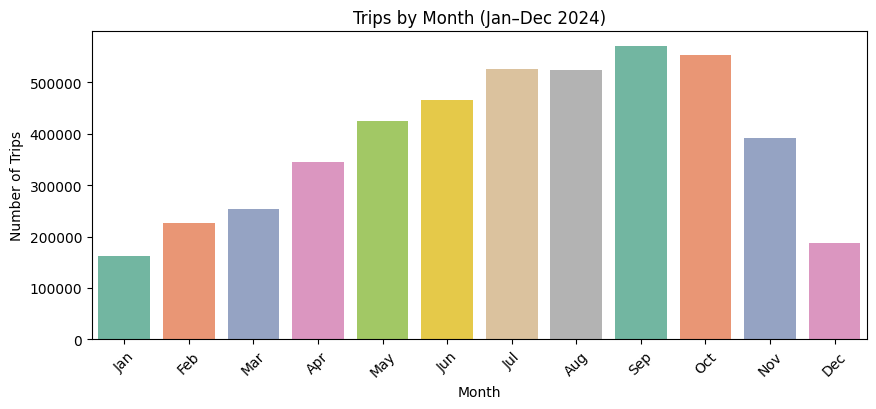

In [27]:
# Trips by month
plt.figure(figsize=(10, 4))
sns.countplot(x='month', data=data, hue='month', palette='Set2', legend=False)
plt.xticks(ticks=np.arange(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks(rotation=45)
plt.title("Trips by Month (Jan–Dec 2024)")
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.show()

3. User Behavior

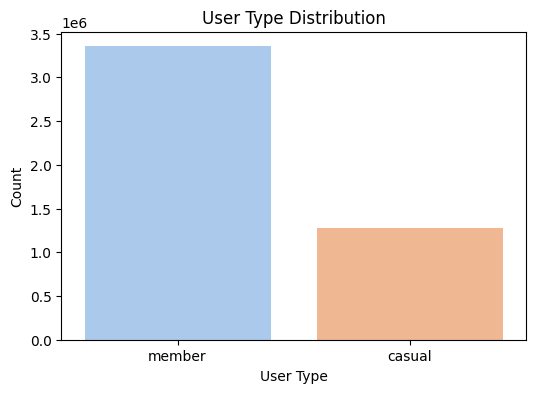

In [28]:
# Distribution of user types
plt.figure(figsize=(6, 4))
sns.countplot(x='member_casual', data=data, hue='member_casual', palette='pastel', legend=False)
plt.title("User Type Distribution")
plt.xlabel("User Type")
plt.ylabel("Count")
plt.show()


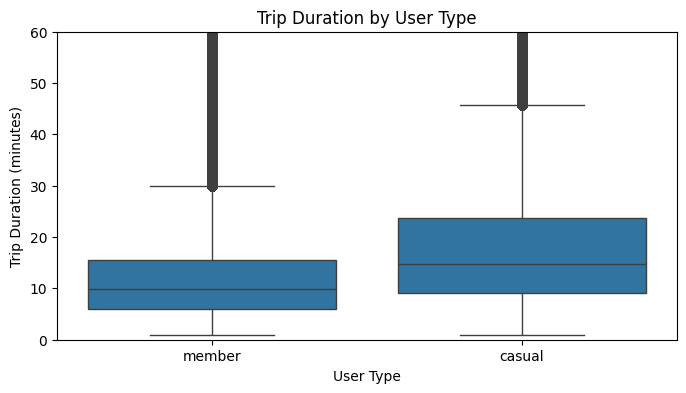

In [29]:
# Trip duration by user type
plt.figure(figsize=(8, 4))
sns.boxplot(x='member_casual', y='trip_duration_min', data=data)
plt.ylim(0, 60)
plt.title("Trip Duration by User Type")
plt.xlabel("User Type")
plt.ylabel("Trip Duration (minutes)")
plt.show()


4. Station Insights

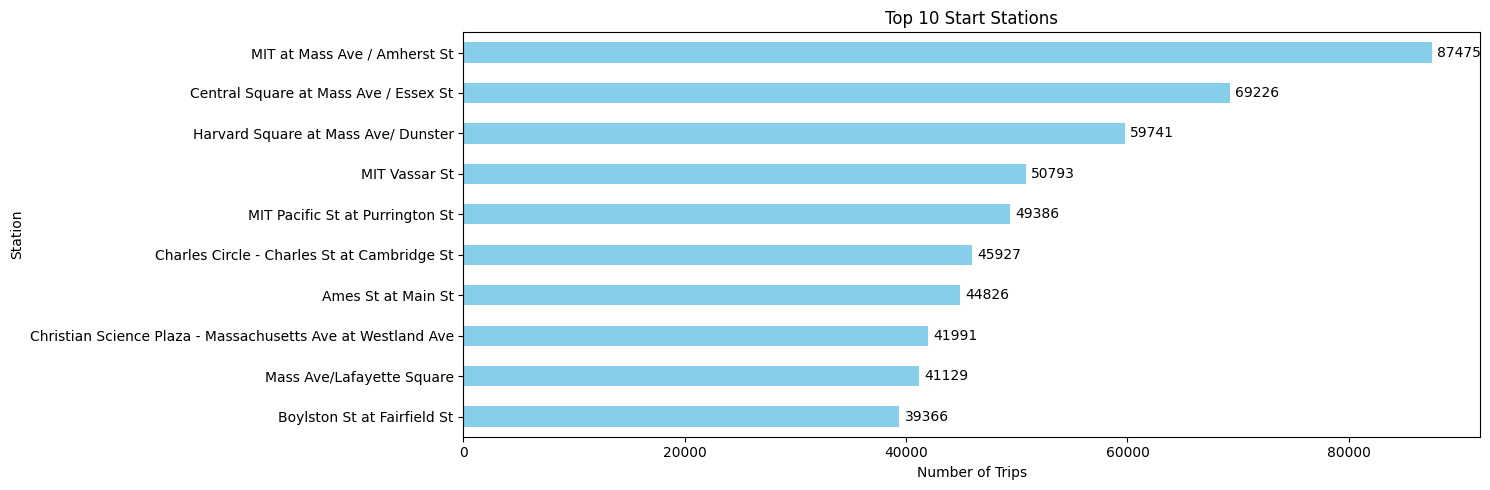

In [30]:
# Top 10 start stations
top_starts = data['start_station_name'].value_counts().head(10).sort_values(ascending=True)

plt.figure(figsize=(15, 5))
ax = top_starts.plot(kind='barh', color='skyblue')
plt.title("Top 10 Start Stations")
plt.xlabel("Number of Trips")
plt.ylabel("Station")
# Add text labels to bars
for i, v in enumerate(top_starts):
    ax.text(v + 500, i, str(v), color='black', va='center')
plt.tight_layout()
plt.show()

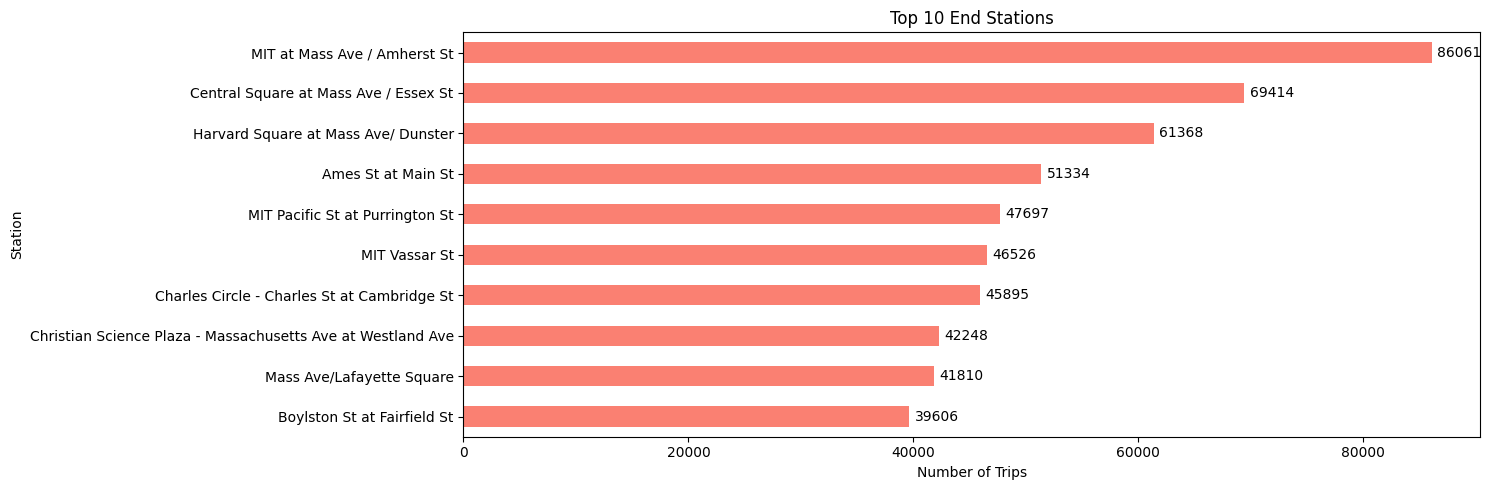

In [31]:
# Top 10 end stations
top_starts = data['end_station_name'].value_counts().head(10).sort_values(ascending=True)

plt.figure(figsize=(15, 5))
ax = top_starts.plot(kind='barh', color='salmon')
plt.title("Top 10 End Stations")
plt.xlabel("Number of Trips")
plt.ylabel("Station")
# Add text labels to bars
for i, v in enumerate(top_starts):
    ax.text(v + 500, i, str(v), color='black', va='center')
plt.tight_layout()
plt.show()

5. Trip Duration Trends Over Time (Daily Average)

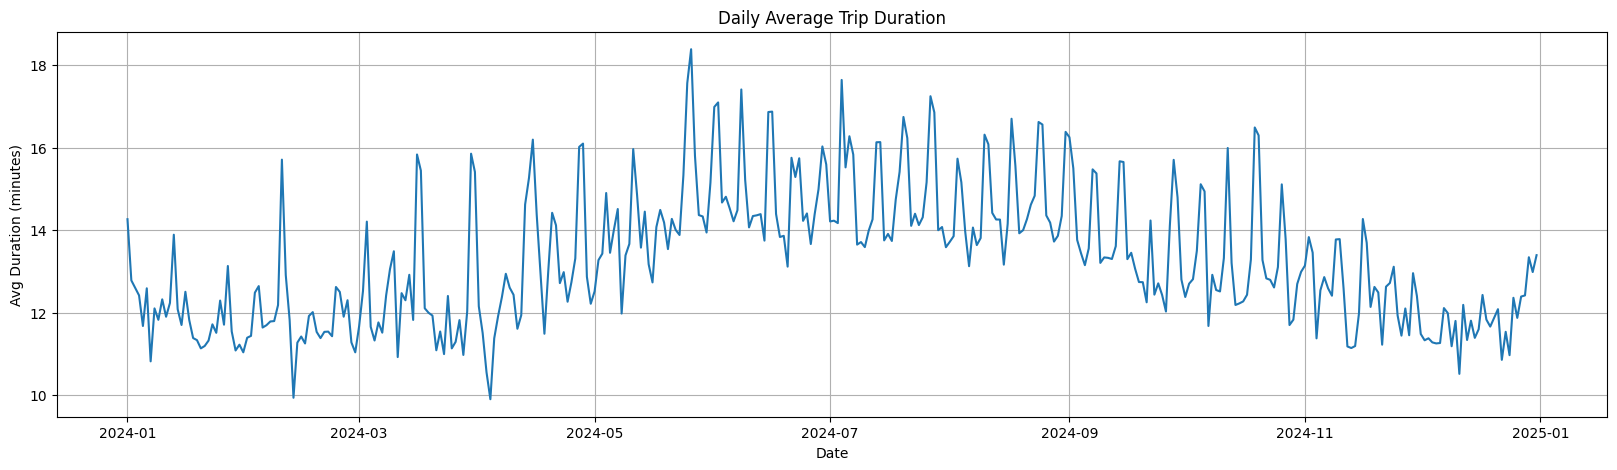

In [32]:
# Daily average trip duration
daily_avg = data.groupby(data['started_at'].dt.date)['trip_duration_min'].mean()

plt.figure(figsize=(20, 5))
daily_avg.plot()
plt.title("Daily Average Trip Duration")
plt.xlabel("Date")
plt.ylabel("Avg Duration (minutes)")
plt.grid(True)
plt.show()


6. Weekly Usage Patterns by User Type

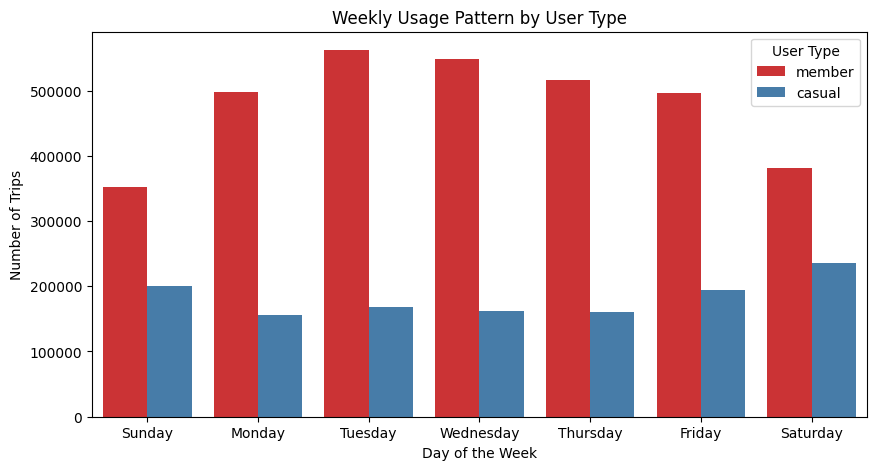

In [33]:
plt.figure(figsize=(10, 5))
sns.countplot(x='weekday', hue='member_casual', data=data, order=order, palette='Set1')
plt.title("Weekly Usage Pattern by User Type")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Trips")
plt.legend(title='User Type')
plt.show()

7. Hourly Usage Patterns by User Type

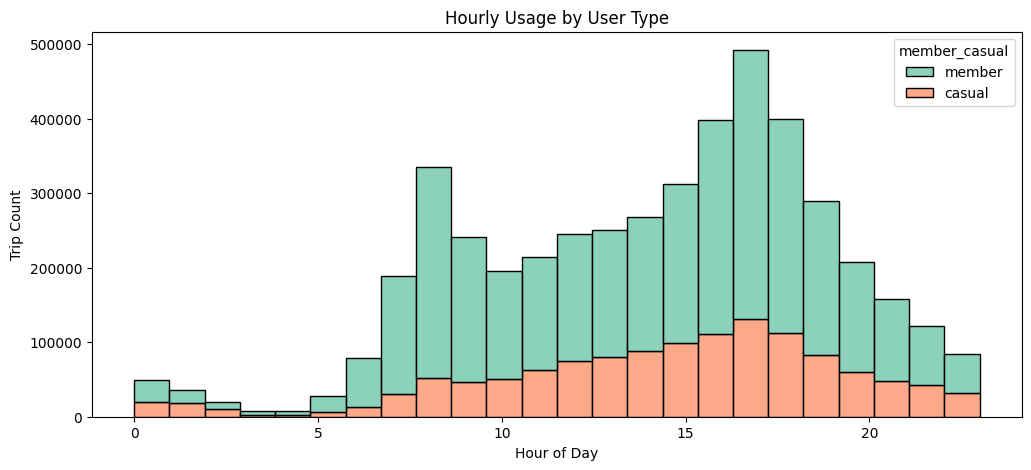

In [34]:
plt.figure(figsize=(12, 5))
sns.histplot(data=data, x='hour', hue='member_casual', multiple='stack', bins=24, palette='Set2')
plt.title("Hourly Usage by User Type")
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.show()

8. Top Origin-Destination Pairs (Routes)

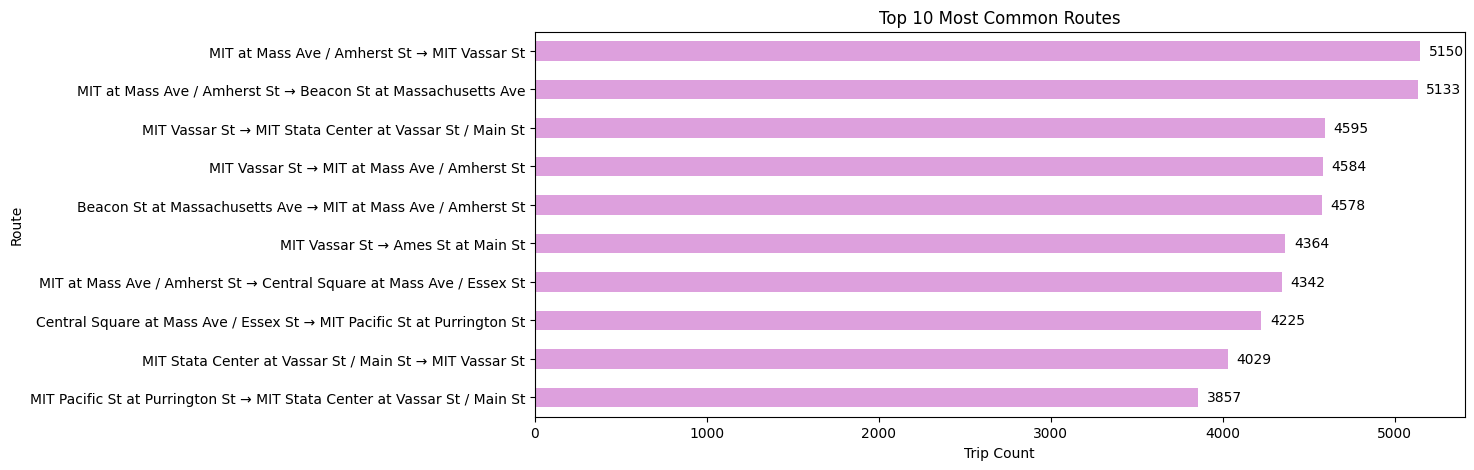

In [35]:
data['route'] = data['start_station_name'] + " → " + data['end_station_name']
top_routes = data['route'].value_counts().head(10).sort_values(ascending=True)

plt.figure(figsize=(12, 5))
ax = top_routes.plot(kind='barh', color='plum')
plt.title("Top 10 Most Common Routes")
plt.xlabel("Trip Count")
plt.ylabel("Route")
# Add text labels to bars
for i, v in enumerate(top_routes):
    ax.text(v + 50, i, str(v), color='black', va='center')
plt.show()


9. Rideable Type Usage

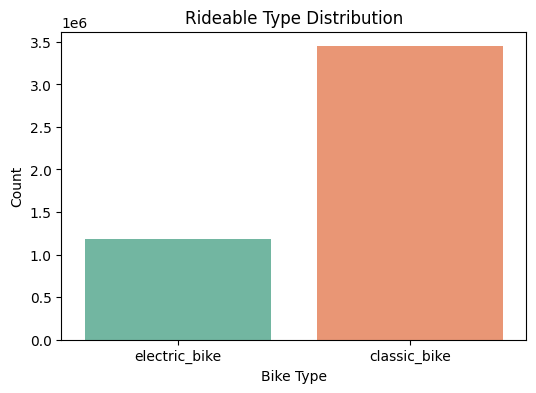

In [36]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rideable_type', data=data, hue='rideable_type', palette='Set2', legend=False)
plt.title("Rideable Type Distribution")
plt.xlabel("Bike Type")
plt.ylabel("Count")
plt.show()

## 1. Trip Duration Prediction

In [37]:
# Install necessary libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Prepare Features and Target

In [38]:
# Define features and target
features = ['distance_km', 'hour', 'weekday', 'month', 'is_weekend', 'member_casual', 'start_station_id', 'end_station_id']
target = 'trip_duration_min'

X = data[features]
y = data[target]

Preprocessing & Encoding

In [39]:
# Define categorical and numeric features
categorical = ['weekday', 'start_station_id', 'end_station_id', 'member_casual']
numeric = ['distance_km', 'hour', 'month', 'is_weekend']

# One-hot encode categorical columns
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

In [40]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Modeling – Linear, Random Forest, XGBoost

In [1]:
# Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)


NameError: name 'Pipeline' is not defined

In [40]:
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(n_estimators=100, random_state=42))
])

# Train the model
lgbm_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lgbm = lgbm_pipeline.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.354316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2416
[LightGBM] [Info] Number of data points in the train set: 3704363, number of used features: 1065
[LightGBM] [Info] Start training from score 13.662593


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [41]:
'''
# Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
'''

"\n# Random Forest\nrf_pipeline = Pipeline([\n    ('preprocessor', preprocessor),\n    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))\n])\nrf_pipeline.fit(X_train, y_train)\ny_pred_rf = rf_pipeline.predict(X_test)\n"

In [42]:
# XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, objective='reg:squarederror'))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

Evaluate Models

In [43]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n📊 {model_name} Evaluation:")
    print("MAE :", round(mean_absolute_error(y_true, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))
    print("R²  :", round(r2_score(y_true, y_pred), 2))

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_lgbm, "ligthgbm")
evaluate_model(y_test, y_pred_xgb, "XGBoost")


📊 Linear Regression Evaluation:
MAE : 4.67
RMSE: 7.35
R²  : 0.44

📊 ligthgbm Evaluation:
MAE : 4.3
RMSE: 6.89
R²  : 0.51

📊 XGBoost Evaluation:
MAE : 4.32
RMSE: 6.92
R²  : 0.51


Hyperparameter Tuning (XGBoost)

In [44]:
from sklearn.model_selection import GridSearchCV
# Parameter grid for tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [4, 6, 8],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [0.8, 1.0]
}

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("\n\n✅ Best Parameters:", grid_search.best_params_)
print("\n📉 Best RMSE Score:", -grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END regressor__learning_rate=0.01, regressor__max_depth=4, regressor__n_estimators=100, regressor__subsample=0.8; total time=  19.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=4, regressor__n_estimators=100, regressor__subsample=0.8; total time=  20.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=4, regressor__n_estimators=100, regressor__subsample=0.8; total time=  22.7s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=4, regressor__n_estimators=100, regressor__subsample=1.0; total time=  22.5s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=4, regressor__n_estimators=100, regressor__subsample=1.0; total time=  22.6s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=4, regressor__n_estimators=100, regressor__subsample=1.0; total time=  23.4s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=4, regressor__n_estimators=200, regressor__subsamp

In [45]:
# Get best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions
y_pred_best = best_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))

# Show results
print(f"✅ R² Score : {r2:.2f}")
print(f"📏 MAE: {mae:.4f}")
print(f"📉 RMSE: {rmse:.4f}")

✅ R² Score : 0.52
📏 MAE: 4.2391
📉 RMSE: 6.8232


## 2. Daily Demand Forecasting (Time Series / ML)

Create Daily Aggregated Data

In [46]:
# Create daily aggregated ride count
daily_rides = data.groupby(data['started_at'].dt.date).size().reset_index(name='ride_count')
daily_rides['date'] = pd.to_datetime(daily_rides['started_at'])
daily_rides = daily_rides.drop(columns='started_at')

# Sort by date
daily_rides = daily_rides.sort_values('date').reset_index(drop=True)

# Preview
daily_rides.head()

,ride_count,date
0,2552,2024-01-01
1,4434,2024-01-02
2,5557,2024-01-03
3,5707,2024-01-04
4,4514,2024-01-05


Feature Engineering for Daily Forecasting

In [47]:
import holidays

# US holidays for 2024
us_holidays = holidays.US(years=2024)

# Basic time features
daily_rides['day_of_week'] = daily_rides['date'].dt.dayofweek  # 0 = Monday
daily_rides['is_weekend'] = daily_rides['day_of_week'].isin([5, 6]).astype(int)
daily_rides['is_holiday'] = daily_rides['date'].isin(us_holidays).astype(int)

# Lag features
daily_rides['lag_1'] = daily_rides['ride_count'].shift(1)
daily_rides['lag_2'] = daily_rides['ride_count'].shift(2)
daily_rides['lag_3'] = daily_rides['ride_count'].shift(3)

# Rolling averages
daily_rides['rolling_3'] = daily_rides['ride_count'].shift(1).rolling(window=3).mean()
daily_rides['rolling_7'] = daily_rides['ride_count'].shift(1).rolling(window=7).mean()

# Drop rows with NaN due to shifting
daily_rides = daily_rides.dropna().reset_index(drop=True)

daily_rides.head()


/var/folders/nz/32xs8mw97l50h0rh3cl625fc0000gn/T/ipykernel_16987/3830006524.py:9: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  daily_rides['is_holiday'] = daily_rides['date'].isin(us_holidays).astype(int)


,ride_count,date,day_of_week,is_weekend,is_holiday,lag_1,lag_2,lag_3,rolling_3,rolling_7
0,3871,2024-01-08,0,0,0,662.0,4134.0,4514.0,3103.333333,3937.142857
1,4853,2024-01-09,1,0,0,3871.0,662.0,4134.0,2889.000000,4125.571429
2,7185,2024-01-10,2,0,0,4853.0,3871.0,662.0,3128.666667,4185.428571
3,7866,2024-01-11,3,0,0,7185.0,4853.0,3871.0,5303.000000,4418.000000
4,7731,2024-01-12,4,0,0,7866.0,7185.0,4853.0,6634.666667,4726.428571


### Prophet (Time Series Forecasting)

Prophet is great for capturing trends, seasonality, and holidays.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
02:27:44 - cmdstanpy - INFO - Chain [1] start processing
02:27:44 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1415: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1415: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1415: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())


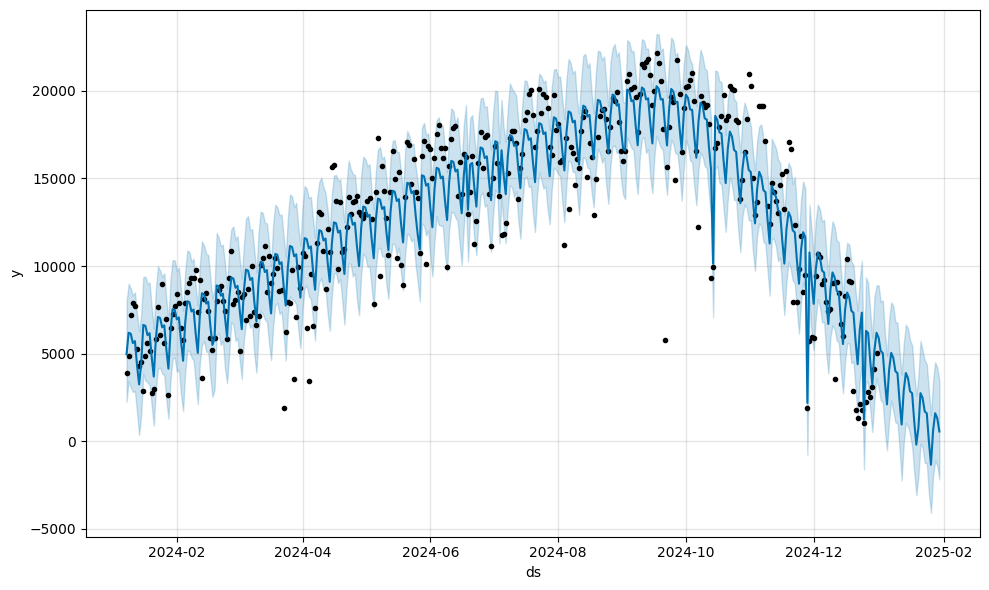

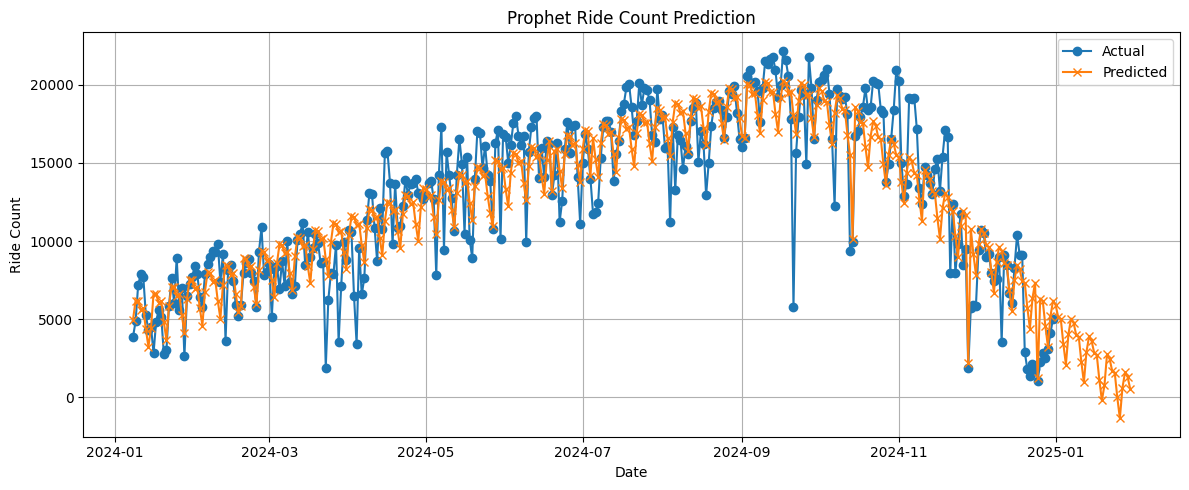

In [48]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = daily_rides[['date', 'ride_count']].rename(columns={'date': 'ds', 'ride_count': 'y'})

# Initialize model and add holiday effect
model = Prophet()
model.add_country_holidays(country_name='US')

# Fit model
model.fit(prophet_df)

# Create future dataframe (e.g., forecast next 30 days)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast);


# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', marker='x')
plt.title("Prophet Ride Count Prediction")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### XGBoost (Machine Learning Forecasting)

In [49]:
# Features and target
X = daily_rides.drop(columns=['date', 'ride_count'])
y = daily_rides['ride_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Model training
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R²: {r2:.2f}")

XGBoost MAE: 2214.22
XGBoost RMSE: 2921.31
XGBoost R²: 0.74


In [50]:
# Assuming 'daily_rides' has 'date' as index or column
X_test.index = daily_rides.loc[X_test.index, 'date']
y_test.index = X_test.index


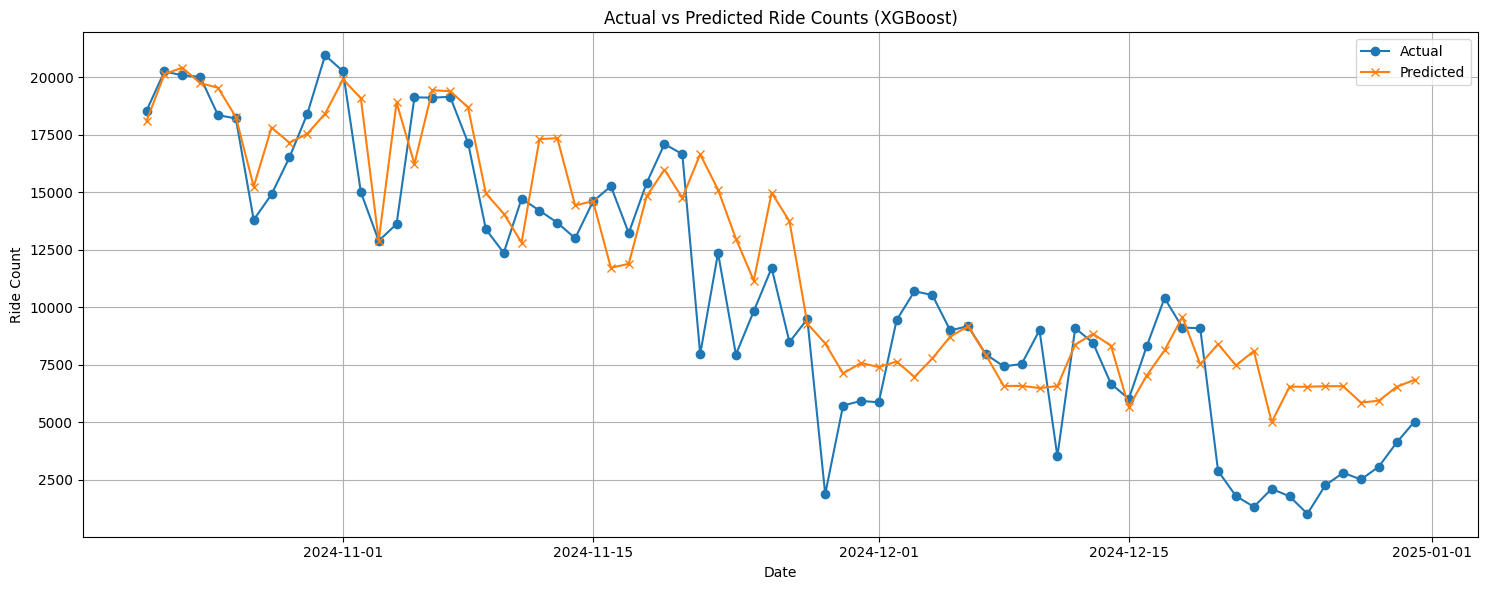

In [51]:
# Actual vs Predicted Plot (XGBoost)
# Plot actual vs predicted
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Ride Counts (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

LightGBM Model

In [52]:
# Train LightGBM
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1)
lgb_model.fit(X_train, y_train)

# Predictions
lgb_pred = lgb_model.predict(X_test)

# Evaluation
lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)

print(f"\n\nLightGBM MAE: {lgb_mae:.2f}")
print(f"LightGBM RMSE: {lgb_rmse:.2f}")
print(f"LightGBM R²: {lgb_r2:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 287, number of used features: 7
[LightGBM] [Info] Start training from score 13320.554007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

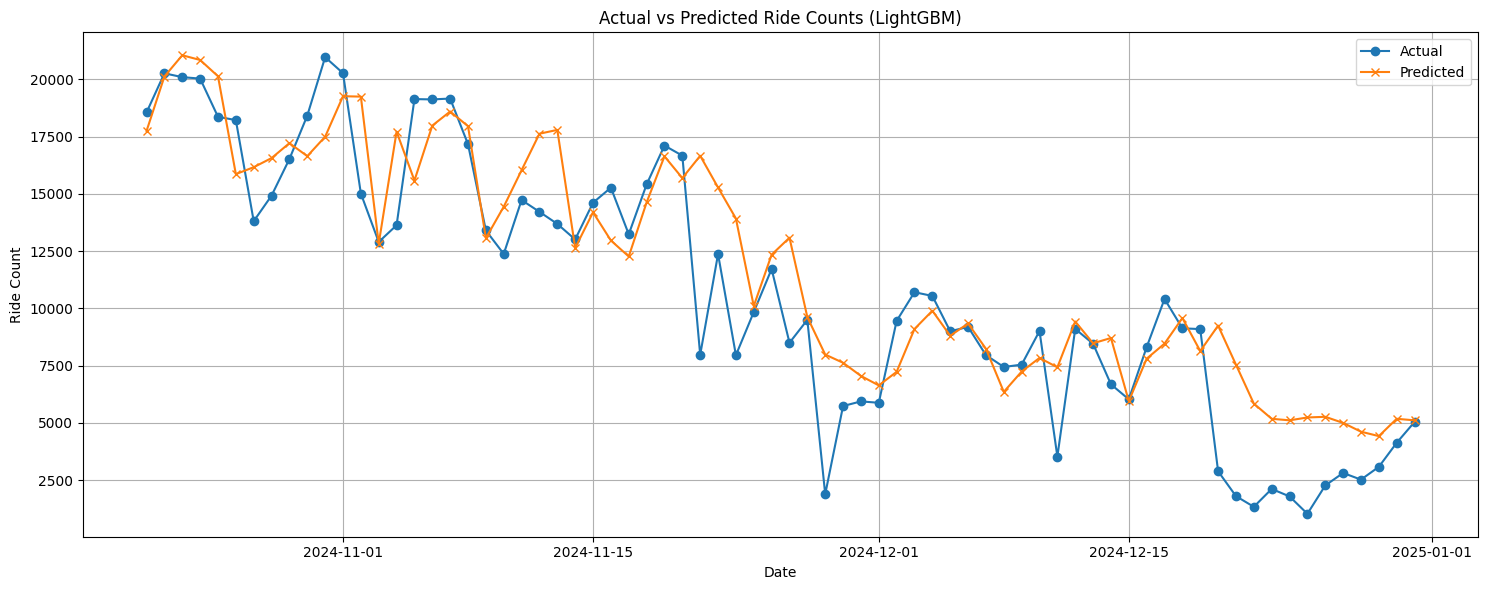

In [53]:
# Actual vs Predicted Plot (LightGBM)
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, lgb_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Ride Counts (LightGBM)')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

CatBoost Model

In [54]:
# Train CatBoost
cat_model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    verbose=0
)
cat_model.fit(X_train, y_train)

# Predict and evaluate
cat_pred = cat_model.predict(X_test)

cat_mae = mean_absolute_error(y_test, cat_pred)
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_pred))
cat_r2 = r2_score(y_test, cat_pred)
print(f"CatBoost MAE: {cat_mae:.2f}")
print(f"CatBoost RMSE: {cat_rmse:.2f}")
print(f"CatBoost R²: {cat_r2:.2f}")

CatBoost MAE: 1917.87
CatBoost RMSE: 2540.53
CatBoost R²: 0.80


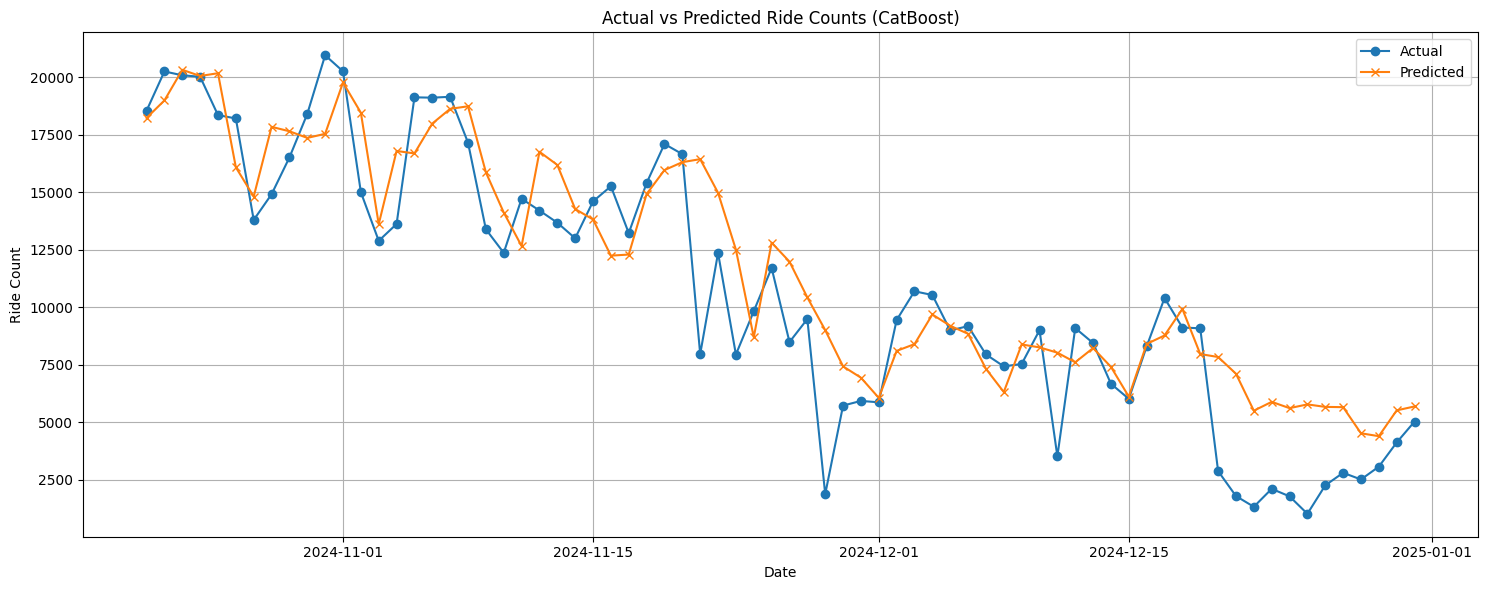

In [55]:
# Plot actual vs predicted for CatBoost
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, cat_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Ride Counts (CatBoost)')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Insights & Recommendations**

**Who’s riding BlueBikes the most?**

The data clearly shows that Subscribers (likely daily commuters or local residents) are the primary users of the system. They ride consistently throughout the weekdays, indicating that BlueBikes plays an important role in their daily routines.

On the other hand, Casual users—probably tourists or occasional riders—are more active during weekends and holidays, which aligns with recreational use.


**When does the system get the most action?**
* Weekday rush hours (especially 7–9 AM and 4–6 PM) are the busiest, driven by commuting patterns.
* Weekend afternoons also see a spike, mainly from casual riders out for leisure.
* Seasonally, summer months (June to August) are the peak season for ridership, with warmer weather encouraging more outdoor travel.


**What can be done to improve operations?**
* **Smart Bike Rebalancing:**
    Focus on moving bikes to high-demand stations before and after rush hours. Prioritize business districts in the mornings and residential zones in the evenings during weekdays. On weekends, rebalance bikes near parks, tourist attractions, and waterfronts.

* **Tailored Marketing Campaigns:**
    Offer commuter perks for subscribers (e.g., monthly challenges or discounts for frequent rides), and promote tourist-friendly packages like 24-hour or weekend passes through local hotels and attractions.

* **Seasonal Fleet Management:**
    Ramp up bike availability and maintenance in warmer months. In colder seasons, consider reducing fleet size or repositioning bikes in indoor docks or transit hubs to cut down idle inventory.

* **User Experience Enhancements:**
    For casual riders, especially tourists, improve station signage, app usability, and provide route suggestions for scenic or safe paths.

* **Strategic Station Expansion:**
    Use trip data to identify underserved hotspots. Expanding into areas with growing residential or office spaces can boost accessibility and increase long-term adoption.
